In [1]:
import torch
import numpy as np
import matplotlib.pyplot as plt
import pickle
%env HDF5_USE_FILE_LOCKING=FALSE
    
import sys
sys.path.insert(1, '../../models/PFN')
from dataset_pfn import PFNDataset
from pfn_model import ParticleFlowNetwork as Model
from torch.utils.data import DataLoader
import pandas as pd
from sklearn.metrics import roc_curve, auc, roc_auc_score, precision_recall_curve
import seaborn as sns
from sklearn.manifold import TSNE
from sklearn.decomposition import PCA

env: HDF5_USE_FILE_LOCKING=FALSE


In [2]:
#Training/Testing path
preprocessed=True
dataset=''
train_path = "../../datasets/train.h5"
val_path = "../../datasets/val.h5"
test_path = "../../datasets/test.h5"

In [3]:
test_set = PFNDataset(test_path, preprocessed)
# test_data, test_mask, test_label = test_set[:]

In [4]:
def evalFC(model, data, mask_indices = [-1], mask_values = [0.]):
    lfs = data.cuda()
    for mask_index, mask_value in zip(mask_indices, mask_values):
        if mask_index >= 0:
            lfs[:, mask_index] = mask_value*torch.ones(lfs[:, mask_index].shape)  
    for ii, layer in enumerate(FcLayers):
        if ii == len(FcLayers)-1: 
            res = layer.forward(lfs).cpu()
        elif ii == len(FcLayers)-2:
            lfs = layer.forward(lfs)
            psmax = lfs.cpu()
        else:
            lfs = layer.forward(lfs)
    return psmax, res

def evalPHI(model, test_set, d_mean = [], mask_indices = []):
    myDL = DataLoader(test_set, batch_size=1024)
    with torch.no_grad():
        for idx, (d, m, l) in enumerate(myDL):
#             d_mean = d.mean(0)
#             print(d.shape, d_mean.shape)
            for mask_index in mask_indices:
#                 if mask_index >= 0:
#                 print(mask_index)
                try:
                    d[:, mask_index[0], mask_index[1]] = d_mean[mask_index[0], mask_index[1]]
                except:
                    d[:, mask_index[0], mask_index[1]] = d_mean[mask_index[1]]
            d2 = torch.flatten(d, start_dim=0, end_dim=1)
            lfs = model._modules['phi'].forward(d2.cuda())
            lfs = torch.stack(torch.split(lfs.permute(1, 0), 200, dim=1), 0)
            lfs = lfs * m.cuda().bool().float()
            lfs = lfs.sum(-1)
            this_lfs = lfs.cpu()  
            psmax, res = evalFC(model, lfs)
            # res = model._modules['fc'].forward(lfs)
            if idx == 0:
                latents = this_lfs.cpu()
                labels = l.cpu()
                presoftmax = psmax.cpu()
                preds = res.cpu()
            else:
                latents = torch.cat((latents, this_lfs.cpu()), 0)
                labels = torch.cat((labels, l.cpu()), 0)
                presoftmax  = torch.cat((presoftmax, psmax.cpu()), 0)
                preds  = torch.cat((preds, res.cpu()), 0)
            if idx == 100:
                break
    return latents, labels, presoftmax, preds


In [5]:
model = Model(input_dims = 3)
model.load_state_dict(torch.load("../../models/PFN/models/PFN_best"))
model = model.cuda()
model.eval()

FcLayers = []
PhiLayers = []
for layer in model._modules['fc']:
    print(layer)
    FcLayers.append(layer)
print('\n')
for layer in model._modules['phi']:
    print(layer)
    PhiLayers.append(layer)

Sequential(
  (0): Linear(in_features=256, out_features=100, bias=True)
  (1): ReLU()
)
Sequential(
  (0): Linear(in_features=100, out_features=100, bias=True)
  (1): ReLU()
)
Sequential(
  (0): Linear(in_features=100, out_features=100, bias=True)
  (1): ReLU()
)
Linear(in_features=100, out_features=2, bias=True)
Softmax(dim=1)


Sequential(
  (0): Linear(in_features=3, out_features=100, bias=True)
  (1): ReLU()
)
Sequential(
  (0): Linear(in_features=100, out_features=100, bias=True)
  (1): ReLU()
)
Sequential(
  (0): Linear(in_features=100, out_features=256, bias=True)
  (1): ReLU()
)


In [6]:
baseline_latents, baseline_labels, baseline_presoftmax, baseline_preds = evalPHI(model, test_set)
auc_baseline = roc_auc_score(baseline_labels[:, 0].numpy(), baseline_preds[:, 0].numpy())*100
print("Baseline model's AUC: {:.4f}%".format(auc_baseline))

Baseline model's AUC: 99.7387%


In [7]:
latent2explore = ['z127', 'z65', 'z62', 'z13', 'z2', 'z236', 'z250', 'z222', 'z210', 'z231', 'z94', 
                  'z45', 'z25', 'z125', 'z179', 'z216', 'z170', 'z56', 'z112', 'z229', 'z96', 'z226', 
                  'z72', 'z54', 'z43', 'z157', 'z87', 'z199', 'z155', 'z115', 'z197', 'z184', 'z212', 
                  'z22', 'z70', 'z84', 'z156', 'z138', 'z251', 'z23', 'z217', 'z142', 'z90', 'z57', 
                  'z223', 'z129', 'z105', 'z213', 'z85', 'z160', 'z221', 'z144', 'z49', 'z124', 'z37', 
                  'z39', 'z95', 'z5', 'z180', 'z188', 'z116', 'z205', 'z61', 'z77', 'z80', 'z50', 
                  'z34', 'z224', 'z38', 'z63', 'z73', 'z175', 'z248', 'z42', 'z202', 'z146', 'z12', 
                  'z131', 'z100', 'z8', 'z172', 'z147', 'z3', 'z117', 'z24']

z_indices = [int(v.replace('z','')) for v in latent2explore]
Nz = len(z_indices)

In [8]:
Ndata = baseline_latents.shape[0]

baseline_latents_red = baseline_latents[:Ndata,:][:, z_indices].detach().cpu().numpy()
baseline_labels = baseline_labels[:Ndata,:]

bkg_indices = (baseline_labels[:, 0] == 1).numpy()
sig_indices = (baseline_labels[:, 1] == 1).numpy()

In [9]:
pca = PCA(n_components=0.99)
pca.fit(baseline_latents_red)

PCA(n_components=0.99)

In [10]:
latents_pca = pca.fit_transform(baseline_latents_red)

/tmp/ipykernel_233232/3163604247.py:3: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  plt.figure(figsize=(8,8))


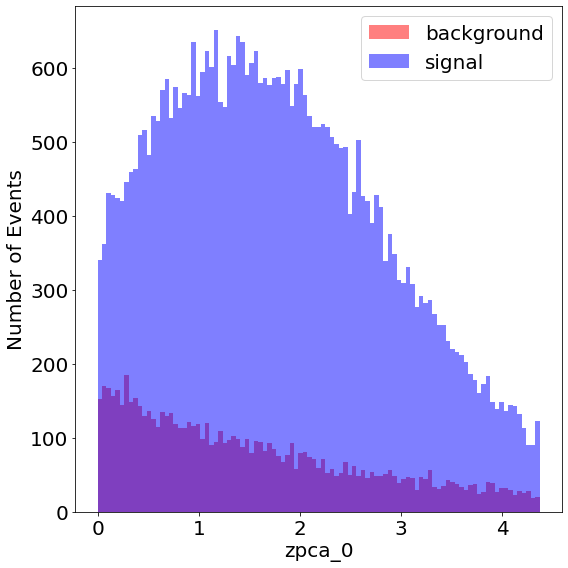

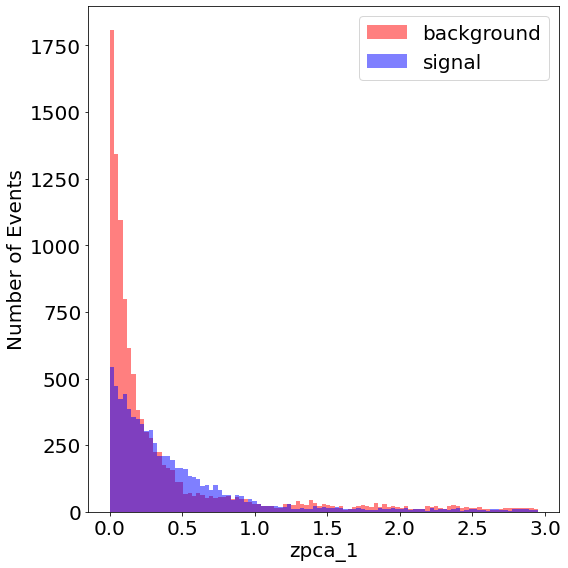

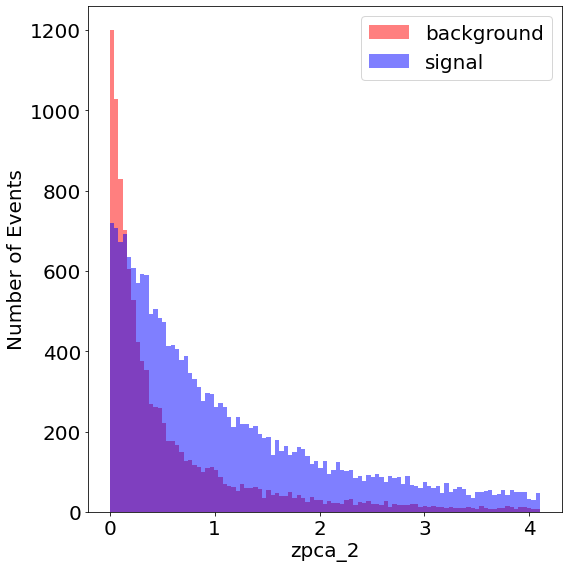

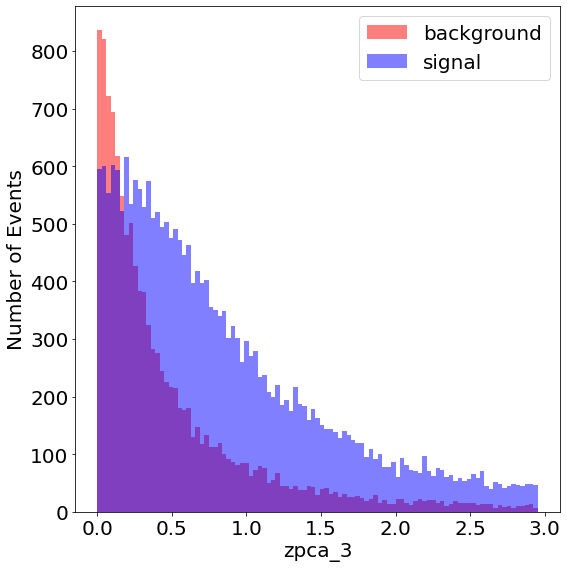

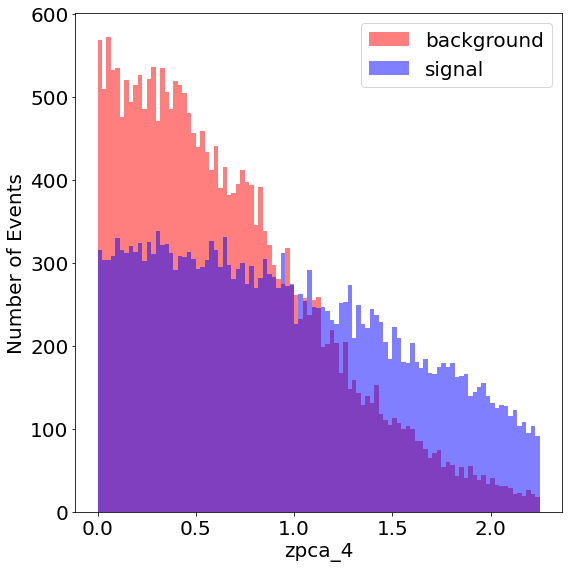

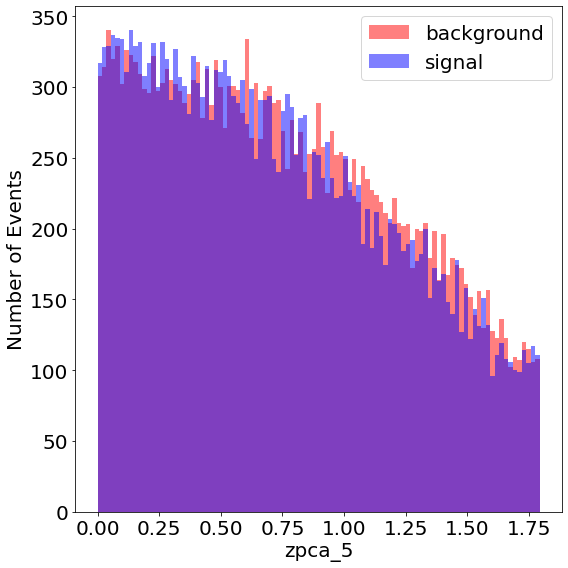

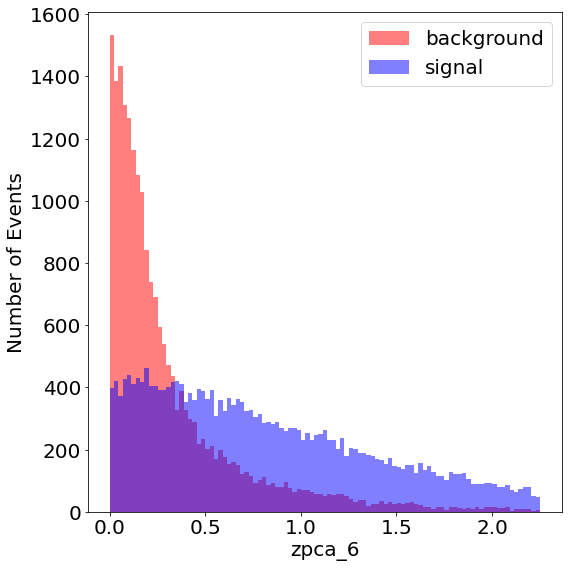

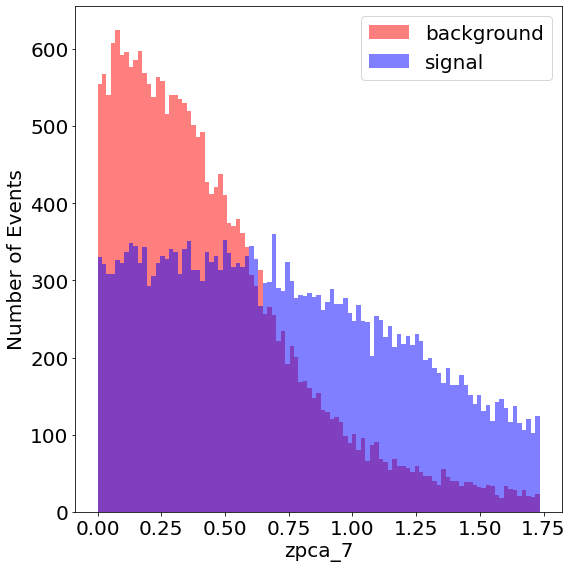

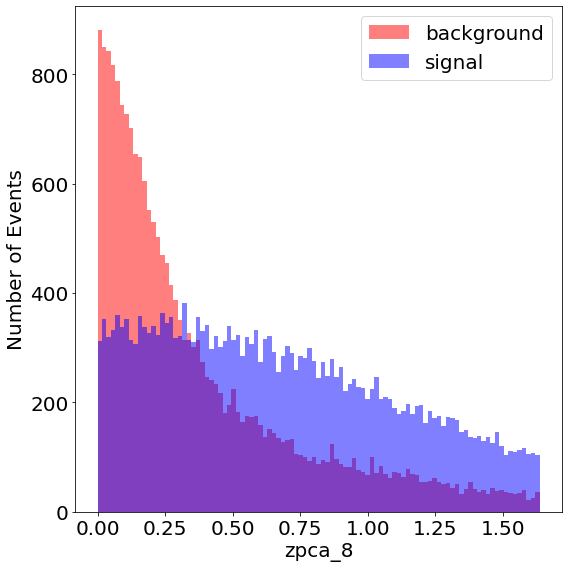

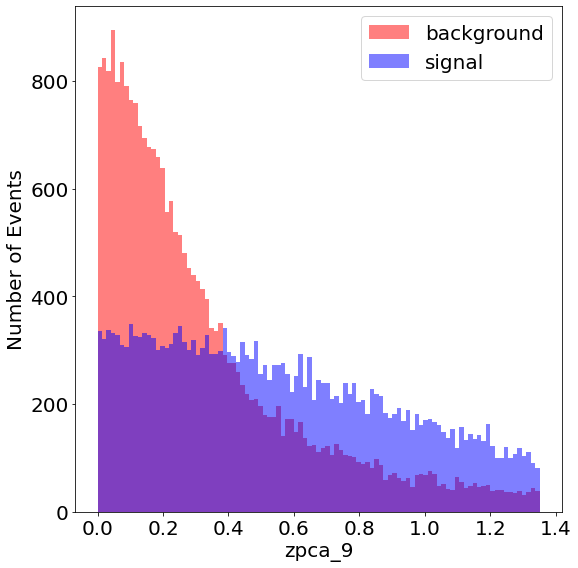

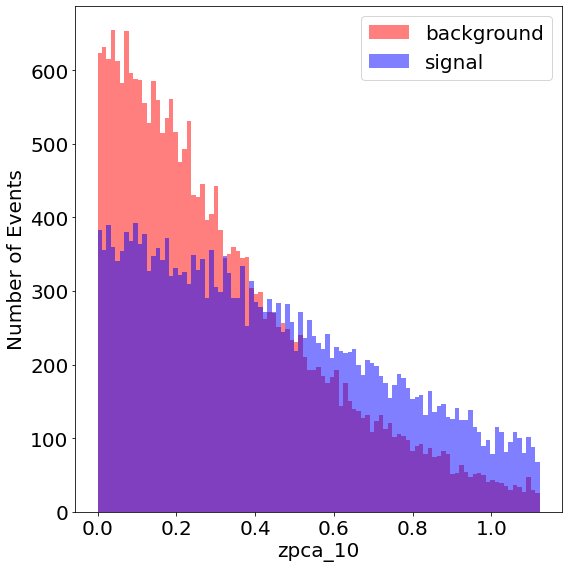

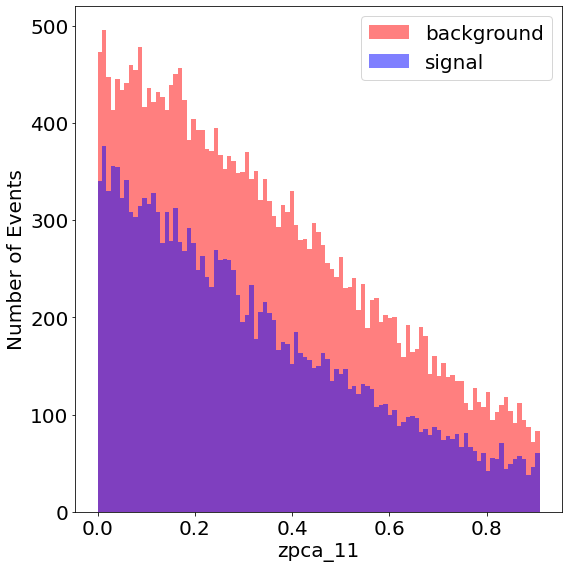

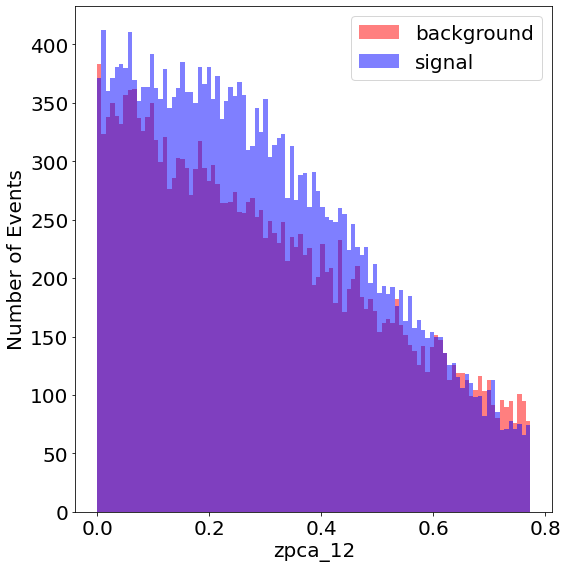

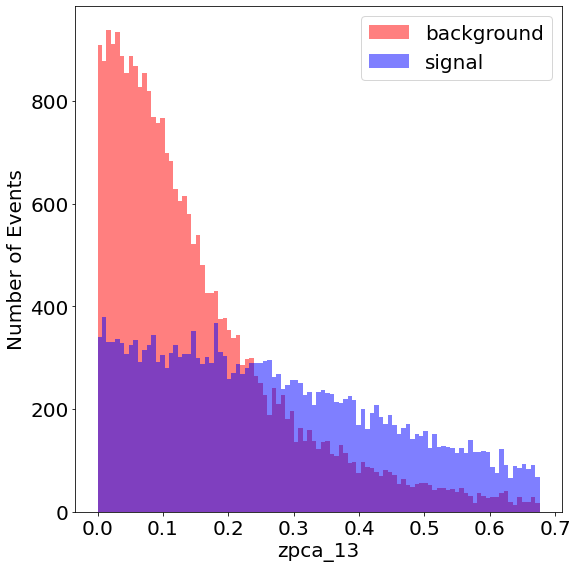

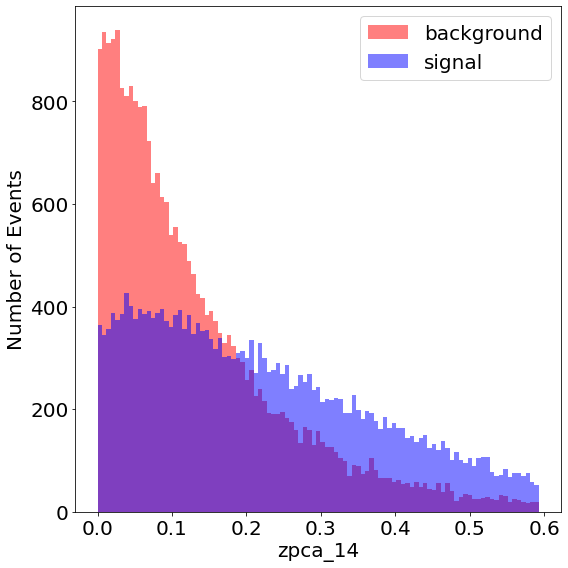

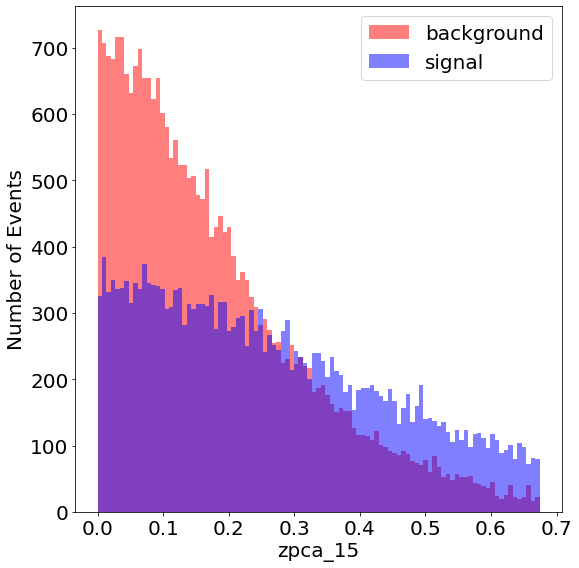

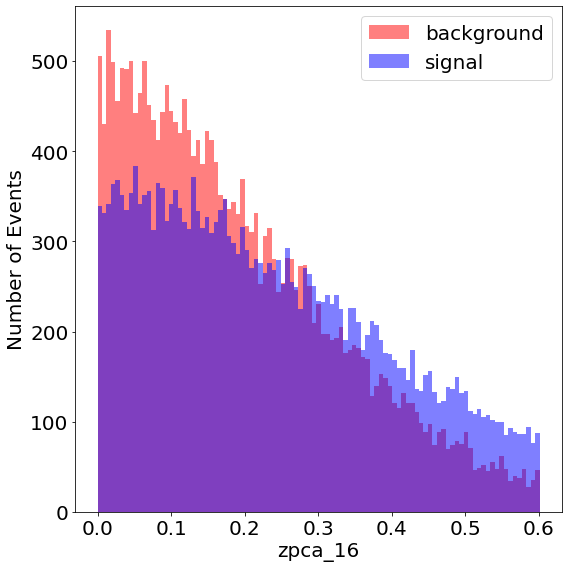

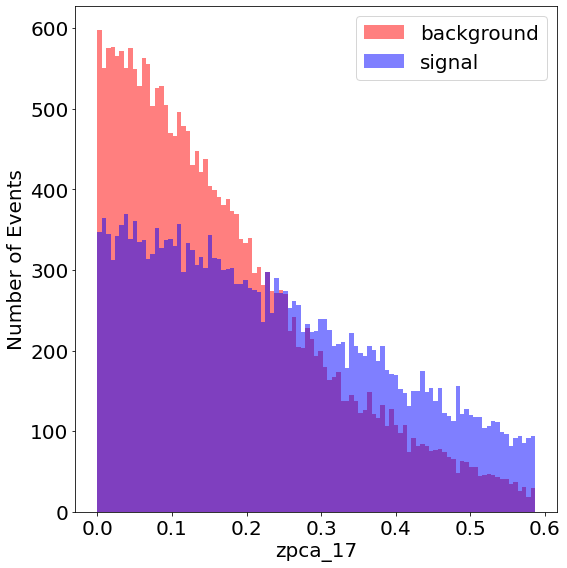

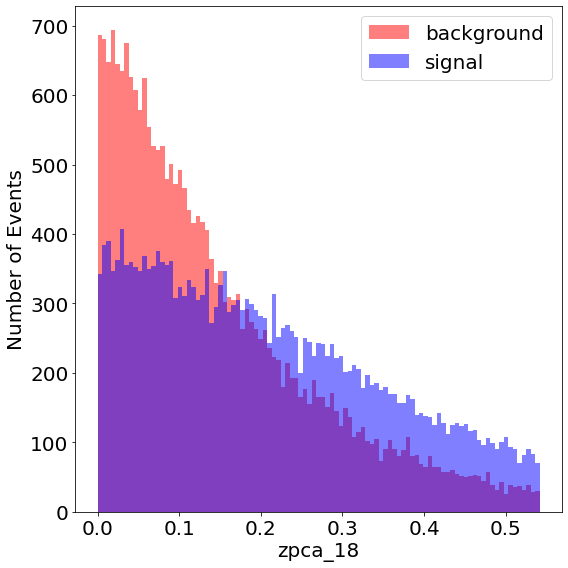

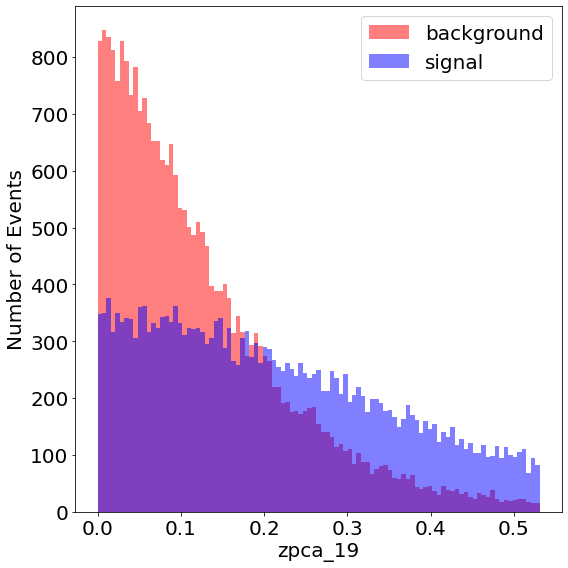

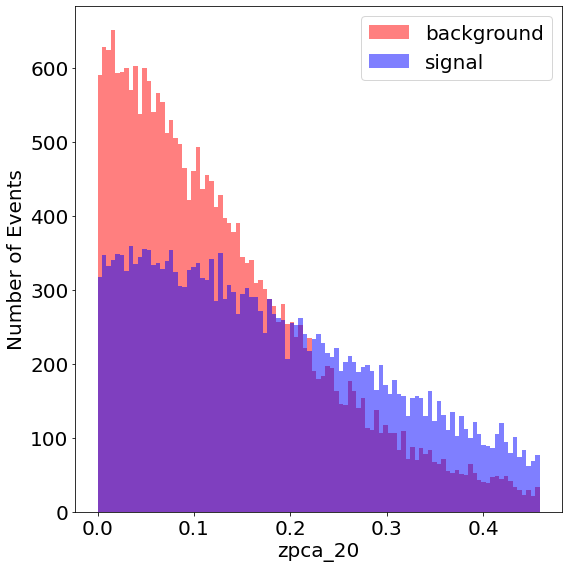

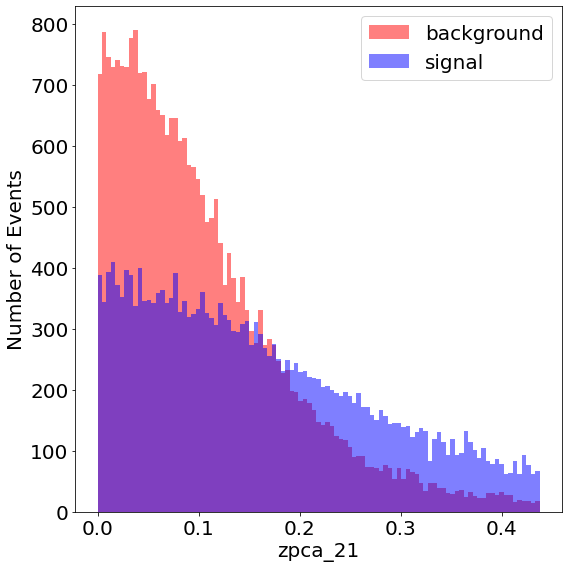

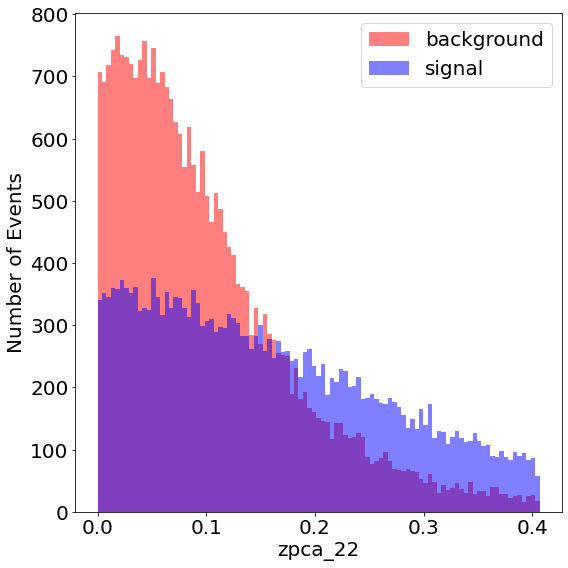

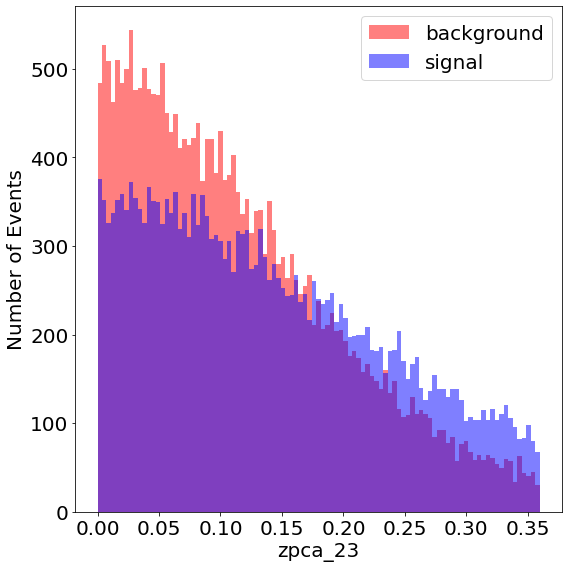

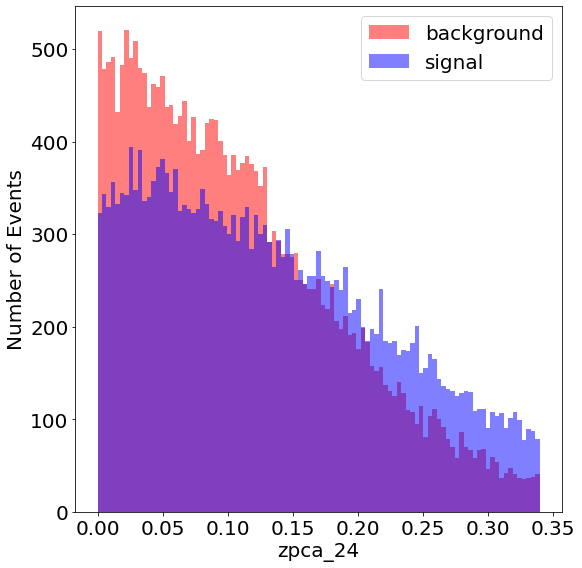

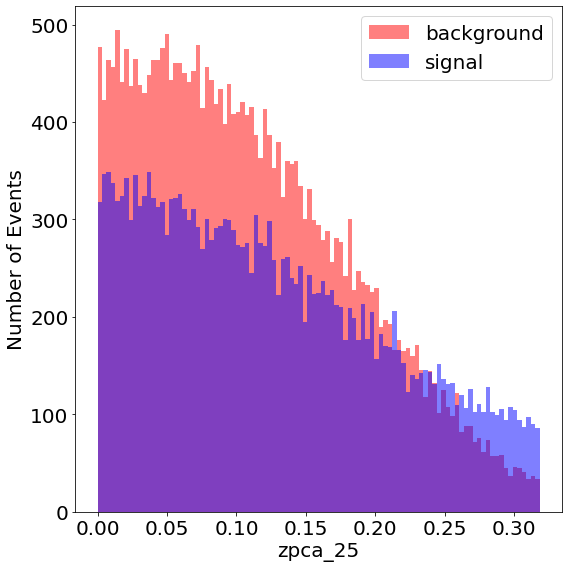

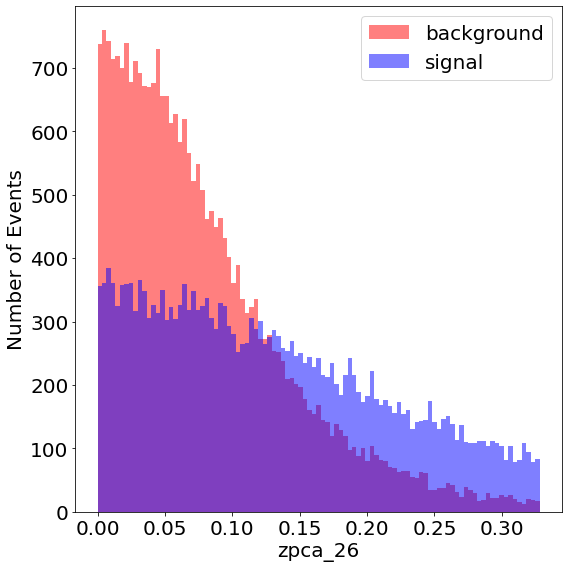

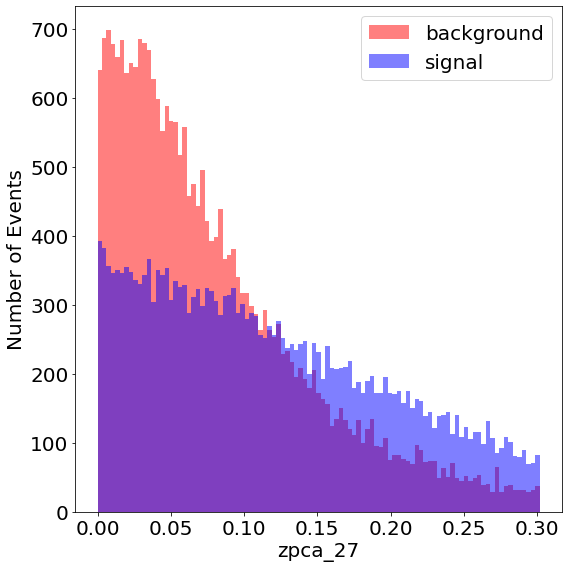

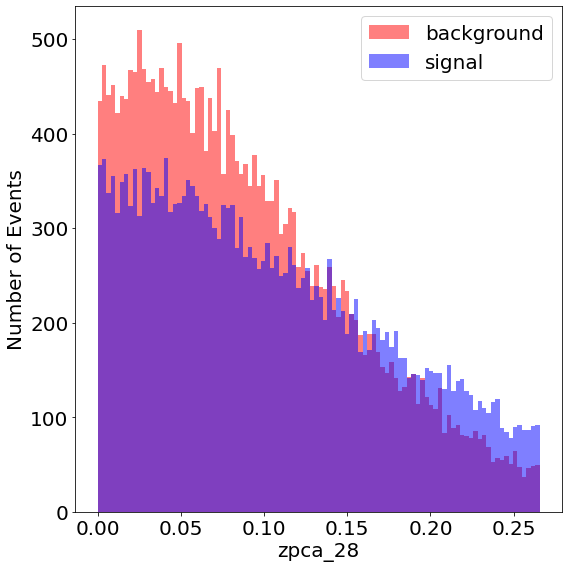

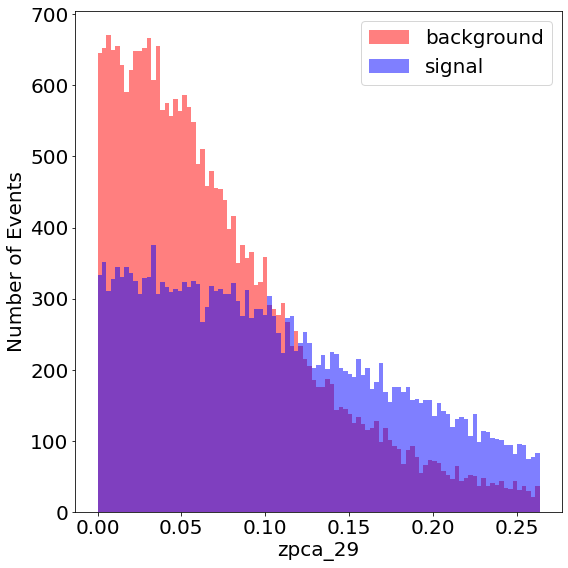

In [11]:
Nz_pca = latents_pca.shape[1]
for ii in range(Nz_pca):
    plt.figure(figsize=(8,8))
    bkg_data = latents_pca[bkg_indices, ii]
    sig_data = latents_pca[sig_indices, ii]
    
    m = max(np.percentile(bkg_data, 95), np.percentile(sig_data, 95))
    plt.hist(bkg_data, bins=np.arange(0,m,m/100), label='background', color='red', alpha=0.5)
    plt.hist(sig_data, bins=np.arange(0,m,m/100), label='signal', color='blue', alpha=0.5)
    plt.xlabel('zpca_{}'.format(ii), fontsize=20)
    plt.ylabel("Number of Events", fontsize = 20)
    plt.tick_params(axis='both', which='major', labelsize=20)
    plt.legend(fontsize = 20)
    plt.tight_layout()
    plt.savefig("figures/latent_dists_baseline/zpca_{}.pdf".format(ii))

/tmp/ipykernel_233232/1043502792.py:17: MatplotlibDeprecationWarning: savefig() got unexpected keyword argument "rasterized" which is no longer supported as of 3.3 and will become an error in 3.6
  plt.savefig("figures/latent_dists_baseline/zpca{}_zpca{}.pdf".format(idx1, idx2),
/tmp/ipykernel_233232/1043502792.py:17: MatplotlibDeprecationWarning: savefig() got unexpected keyword argument "rasterized" which is no longer supported as of 3.3 and will become an error in 3.6
  plt.savefig("figures/latent_dists_baseline/zpca{}_zpca{}.pdf".format(idx1, idx2),


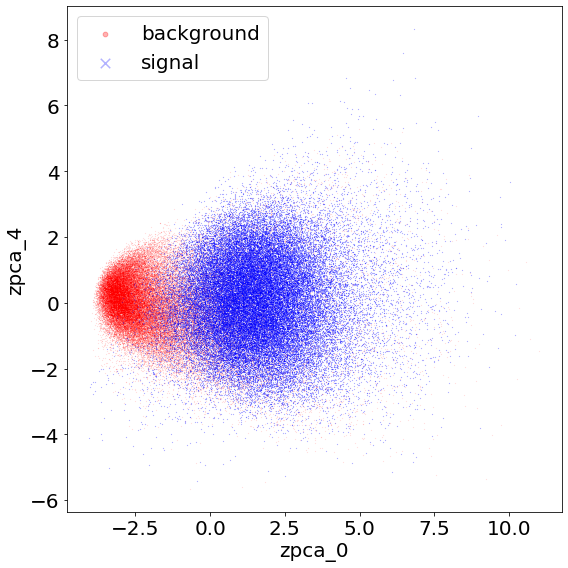

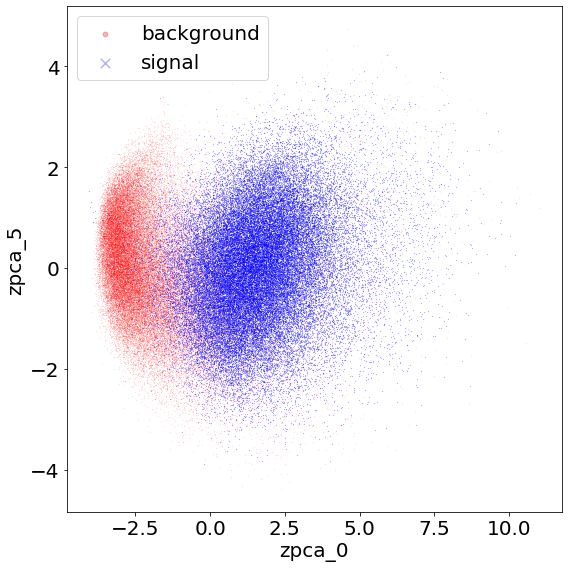

In [12]:
ID1 = [0]
ID2 = [4, 5]


for idx1 in ID1:
    for idx2 in ID2:
        plt.figure(figsize = (8,8))
        plt.scatter(latents_pca[bkg_indices, idx1], latents_pca[bkg_indices, idx2], color = 'red', 
                                marker = '.', label = 'background', alpha=0.3, s = 0.1)
        plt.scatter(latents_pca[sig_indices, idx1], latents_pca[sig_indices, idx2], color = 'blue', 
                                marker = 'x', label = 'signal', alpha=0.3, s = 0.1)
        plt.xlabel('zpca_{}'.format(idx1), fontsize=20)
        plt.ylabel('zpca_{}'.format(idx2), fontsize=20)
        plt.tick_params(axis='both', which='major', labelsize=20)
        plt.legend(markerscale = 30, fontsize = 20)
        plt.tight_layout()
        plt.savefig("figures/latent_dists_baseline/zpca{}_zpca{}.pdf".format(idx1, idx2), 
                    rasterized=True)
        
        
        
# # legend = plt.legend()
# # for legend_handle in legend.legendHandles:
# #     legend_handle._legmarker.set_markersize(9)
# plt.show()
# plt.scatter(latents_pca[bkg_indices, idx1], latents_pca[bkg_indices, idx2], color = 'red', 
#             marker = '.', label = 'background', alpha=0.1, s = 0.1)
# plt.show()
# plt.scatter(latents_pca[sig_indices, idx1], latents_pca[sig_indices, idx2], color = 'blue', 
#             marker = 'x', label = 'signal', alpha=0.1, s = 0.1)

In [13]:
pca.explained_variance_ratio_

array([0.25066434, 0.19600669, 0.12160105, 0.08319553, 0.06504938,
       0.0550391 , 0.04733136, 0.0374818 , 0.03029859, 0.02188815,
       0.01480789, 0.0099218 , 0.00865814, 0.0063216 , 0.00595321,
       0.00533384, 0.00428523, 0.00400373, 0.00369984, 0.00305839,
       0.00274345, 0.002276  , 0.00200425, 0.00183209, 0.00169938,
       0.00137742, 0.00120818, 0.00105239, 0.00098129, 0.00084913])

In [14]:
Ndata_tsne = 100000
latents_pca_red = latents_pca[:Ndata_tsne, :20]
bkg_indices_red = bkg_indices[:Ndata_tsne]
sig_indices_red = sig_indices[:Ndata_tsne]
np.save("bkgIndices.npy", bkg_indices_red)
np.save("sigIndices.npy", sig_indices_red)

In [ ]:
do_tsne = True
if do_tsne:
    tsne = TSNE(n_components=2,
                init="random",
                random_state=0,
                perplexity=100,
                learning_rate="auto")

    z_tsne = tsne.fit_transform(latents_pca_red)
    np.save("zTSNE.npy", z_tsne)

z_tsne = np.load("zTSNE.npy")    

In [ ]:
plt.figure(figsize=(8,8))
plt.scatter(z_tsne[bkg_indices_red, 0], z_tsne[bkg_indices_red, 1], 
            color = 'red', marker = '.', label = 'background', alpha=0.2, s = 0.2)
plt.scatter(z_tsne[sig_indices_red, 0], z_tsne[sig_indices_red, 1], 
            color = 'blue', marker = 'x', label = 'signal', alpha=0.2, s = 0.2)
plt.tick_params(axis='both', which='major', labelsize=20)
plt.legend(markerscale = 30, fontsize = 20)
plt.axis('off')
plt.tight_layout()
plt.savefig("figures/latent_dists_baseline/tsne.pdf".format(idx1, idx2))
plt.show()

In [ ]:
coeffs = pca.components_
coeffs.shape

In [ ]:
coeffs[0]